In [1]:
#Loading Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
#Loading in Files
file_path = r"C:\Users\strou\Desktop\Machine Learning\Project 2\Data\project_adult.csv"
file_path_valid  = r"C:\Users\strou\Desktop\Machine Learning\Project 2\Data\project_validation_inputs.csv"

df = pd.read_csv(file_path, na_values='?')
df_valid = pd.read_csv(file_path_valid, na_values='?')

In [3]:
#Define a Function to Preprocess the Data
def preprocess_data(df):

  #Change income to a binary variable
  if 'income' in df.columns:
    df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

  #Get rid of education because it's the same as education num but not ordinal

  #drop na
  if 'workclass' in df.columns:
     df['workclass'].replace('?', np.nan)

  if 'occupation' in df.columns:
     df['occupation'].replace('?', np.nan)

  if 'native-country' in df.columns:
    df['native-country'].replace('?', np.nan)

  # Select categorical columns (object or category types)
  categorical_cols = df.select_dtypes(include=['object', 'category']).columns

  # Initialize encoder
  le = LabelEncoder()

  # Apply LabelEncoder to each categorical column in place
  for col in categorical_cols:
      df[col] = le.fit_transform(df[col])

  return df

In [4]:
#Actually preprocess data
df = preprocess_data(df)
df_valid = preprocess_data(df_valid)

In [5]:
# split data into training and test datasets
train = df.drop('income', axis=1) # Features are all columns except 'Unnamed: 0' and 'income'
X = train
y = df['income'] # Target is the 'income' column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify = y)

In [6]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Convert outputs to numpy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [7]:
###LIST OF HYPERPARAMETERS THAT NEED TUNING
#Batch size (start with a standard size of 50)
#Number of Epochs (test out multiple)
#Number of Hidden Layers and number of computed values in hidden layers

In [8]:
#Import Training and Test sets as tensors
X_train_t = torch.from_numpy(X_train_scaled).float()
X_test_t = torch.from_numpy(X_test_scaled).float()
y_train_t = torch.from_numpy(y_train).float()
y_test_t = torch.from_numpy(y_test).float()

#Create a Tensor Dataset for training and test sets
Tensor_train = TensorDataset(X_train_t, y_train_t)

In [9]:
#Shuffling training batches (starting with 50 to test)
torch.manual_seed(67)
train_dl = DataLoader(Tensor_train, batch_size=50, shuffle=True)

In [10]:
# Creating model class for testing model
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.layer2 = nn.Linear(hidden_size, 2)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.tanh(x)
        return x


In [11]:
#Setting Parameters
input_size = X_train_t.shape[1]
hidden_size = 20

In [12]:
#Set model and Loss function
model = Model(input_size, hidden_size)
loss_fn = nn.CrossEntropyLoss()

In [13]:
#Set learning Rate and Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
#Running the model
num_epochs = 250
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

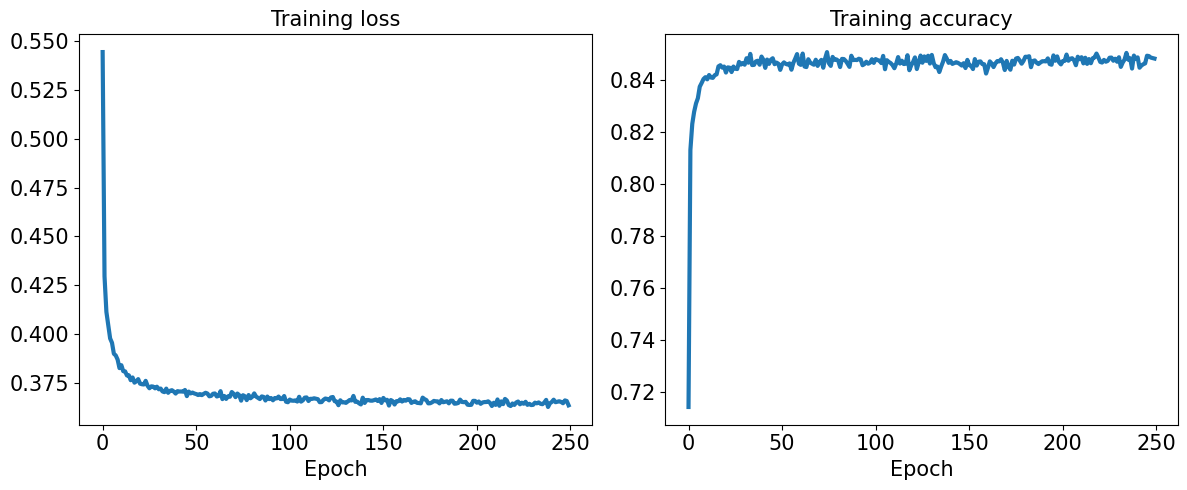

In [15]:
#Plotting Training loss and Training Accuracy
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

In [16]:
#Computing Validation Accuracy on the Dataset
model.eval()
with torch.no_grad():
    pred = model(X_test_t)
    is_correct = (torch.argmax(pred, dim=1) == y_test_t).float()
    print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.8466


In [20]:
#Run the tests on the validation set
df_valid_scaled = scaler.transform(df_valid)
X_new_t = torch.from_numpy(df_valid_scaled).float()

model.eval()
with torch.no_grad():
    pred = model(X_new_t)                     # shape: [num_samples, 2]
    predicted_classes = torch.argmax(pred, dim=1)  # 0 or 1

# Map classes: 0 → -1, 1 → +1
predicted_labels = predicted_classes.clone()
predicted_labels[predicted_labels == 0] = -1
predicted_labels[predicted_labels == 1] = 1

# Save predictions to CSV
pred_df = pd.DataFrame(predicted_labels.tolist())
pred_df.to_csv("Group_1_MLP_PredictedOutputs.csv", index=False, header=False)
